# ML Reglas de Precio

Objetivo: Identificar características importantes para asignación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:  
    - Día (Day)CONFIGURABLE  
    - Día de la semana (Weekday)  
    - Sitio (Site) CONFIGURABLE  
    - Tamaño de creativo (Creative Size) CONFIGURABLE  
    - Dispositivo (Device category) CONFIGURABLE  
    - País (Country) CONFIGURABLE  
    - Nombre Regla de Precio (pricing rule name)

Variables disponibles cuantitativas:  
    - Regla de Precio
    - Ad Requests.  
    - Matched Requests.  
    - Clicks.  
    - Estimated Revenue  
    - Ad Impressions  
    - Active View Enabled Impressions  
    - Active View measured Impressions  
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Target: Maximizar ingresos (revenue)  
Inputs: weekday, site, creative_size, device_category, country.  
Output: Regla de Precio.

In [247]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [248]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [249]:
# Carga de archivo base de datos con 9,994 registros, de los cuales información mensual desde Agosto 2020
import os
import tarfile
import urllib.request
import pandas as pd

PRULES_PATH = os.path.join("datasets")

def load_prules_data(prules_path=PRULES_PATH,filename="newbase_pricing_rules_open.csv"):
    csv_path = os.path.join(prules_path, filename)
    return pd.read_csv(csv_path)

# Definición de funciones

In [250]:
# PARA PRIMERAS PRUEBAS Y ANÁLISIS DE COMPORTAMIENTO, TOMAMOS SOLAMENTE INFORMACIÓN DE EXCÉLSIOR.
# Visualización de la carga
target_site = 'Excelsior'

carga_prules = pd.concat([load_prules_data(filename="pt1_newbase_pricing_rules_open.csv"),load_prules_data(filename="pt2_newbase_pricing_rules_open.csv")])

prules = carga_prules[carga_prules['site'] == target_site]
prulesorg = carga_prules[carga_prules['site'] == target_site]

In [251]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X['rCPM'] = X['revenue']/X['ad_requests']*1000
        X['FillRate'] = X['ad_impressions']/X['ad_requests']
        X['eCPM'] = X['revenue']/X['ad_impressions']*1000
        return X

In [252]:
attr_adder = CombinedAttributesAdder()
prules = attr_adder.transform(prules)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests']
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [253]:
def categorise(row,dfgb,porc):
    cpm_inst = row['eCPM'] # Se obtiene el CPM de la instancia
    c_size = row['creative_size'] # Se obtiene el creative_size de la instancia
    cpm_pond = (dfgb.loc[c_size]['revenue']/dfgb.loc[c_size]['ad_impressions']*1000) # Se obtiene el CPM general del creative size
    
    if cpm_inst > cpm_pond*(1+porc): # Se compara cpm de la instancia vs cpm general del creative size
        return 1
    else:
        return 0 

In [254]:
# Clase de primer estrategia
class StrategyCPMSuperior(BaseEstimator, TransformerMixin):
    def __init__(self, porc=0, fill_rate=.60, limit_cpm=150): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, porc=0, fill_rate=.60, limit_cpm=150):
        Xgb = X.groupby('creative_size').sum()
        #print(prulesgb.loc['1x1']['ad_impressions'])
        X['flag_cpm_sup'] = X.apply(lambda row: categorise(row,Xgb,porc), axis=1)
        X = X[(X['FillRate']>fill_rate) & ((X['flag_cpm_sup']==1) & (X['eCPM']<limit_cpm))]
        X = X.reset_index(drop = True)
        return X

In [255]:
st_CPMsup = StrategyCPMSuperior()
prulescpm = st_CPMsup.transform(prules, porc=0,fill_rate=.60,limit_cpm=150)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\1013332295.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['flag_cpm_sup'] = X.apply(lambda row: categorise(row,Xgb,porc), axis=1)


In [256]:
prulesgbcpm = prulescpm.groupby('creative_size').count()
prulesgbcpm['pricing_rules'].head(20)

creative_size
300x100          157
300x250         2559
300x600          692
320x100          306
320x50           226
728x90          2998
Native            11
Sin Posicion    2355
Name: pricing_rules, dtype: int64

In [257]:
def categorise_pricing(row,porc):
    if row['ad_impressions'] > 0:
        real_pricing = row['revenue']/row['ad_impressions'] # Se obtiene el CPM de la instancia
        floor_pricing = row['pricing_rules']*row['ad_impressions']/1000000
    else:
        real_pricing = 0
        floor_pricing = 0
    
    if real_pricing > floor_pricing*(1+porc): # Se compara real pricing con floor pricing, con un % mínimo
        return 1
    else:
        return 0 

In [258]:
class StrategyRealvsFloorPricing(BaseEstimator, TransformerMixin):
    def __init__(self, porc=0, fill_rate=.60, limit_cpm=150): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, porc=0, fill_rate=.60, limit_cpm=150):
        X['flag_pricing_sup'] = X.apply(lambda row: categorise_pricing(row,porc), axis=1)
        X = X[(X['FillRate']>fill_rate) & ((prules['flag_pricing_sup']==1) & (prules['eCPM']<limit_cpm))]
        X = X.reset_index(drop = True)
        return X

In [259]:
st_realp = StrategyRealvsFloorPricing()
prulesrealp = st_realp.transform(prules, porc=.10,fill_rate=.60,limit_cpm=150)
prulesgbrp = prulesrealp.groupby('creative_size').count()
prulesgbrp['pricing_rules'].head(20)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3647542426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['flag_pricing_sup'] = X.apply(lambda row: categorise_pricing(row,porc), axis=1)


creative_size
300x100           47
300x250         4118
300x600          907
320x100          265
320x50           624
728x90          3602
Native            11
Sin Posicion    3805
Tags               3
Name: pricing_rules, dtype: int64

In [260]:
class Strat_sets(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        X["pr_cat"] = pd.cut(X["pricing_rules"],
                               bins=[-np.inf, 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(X, X["pr_cat"]):
            X_train_set = X.loc[train_index]
            X_test_set = X.loc[test_index]
        return X_train_set, X_test_set

# Pipelines

In [261]:
clean_cpm_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('strategy_cpm', StrategyCPMSuperior(porc=-.20,fill_rate=.60,limit_cpm=150)),
        ('stratified',Strat_sets()),
])

prcpm_train, prcpm_test = clean_cpm_pipeline.transform(prulesorg)
prcpmgbt = prcpm_train.groupby('creative_size').count()
prcpmgbt['pricing_rules'].head(20)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests']
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

creative_size
300x100          127
300x250         2018
300x600          555
320x100          245
320x50           179
728x90          2396
Native            10
Sin Posicion    1913
Name: pricing_rules, dtype: int64

In [275]:
clean_realp_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('strategy_cpm', StrategyRealvsFloorPricing(porc=.10,fill_rate=.60,limit_cpm=150)),
        ('stratified',Strat_sets()),
])

realp_train, realp_test = clean_realp_pipeline.transform(prulesorg)
# Se asignan etiquetas para set de training
realp = realp_train.drop("pricing_rules", axis=1) # drop labels for training set
realp_labels = realp_train["pricing_rules"].copy()

# Se asignan etiquetas para set de testing
realp_test_labels = realp_test["pricing_rules"].copy()
realp_test = realp_test.drop("pricing_rules", axis=1)

# GENERAR ETIQUETAS DE TESTING

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests']
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\2430769537.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [276]:
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
# REVISAR SI EXISTE OTRO DATAFRAMESELECTOR NUEVO Y PONERLO ARRIBA PARA USARLO EN ERRORES DE VISUALIZACIÓN DE .HEAD().

In [277]:
#num_attribs = ['revenue']
cat_attribs = ['weekday', 'creative_size', 'device', 'country']

#old_num_pipeline = Pipeline([
#        ('selector', OldDataFrameSelector(num_attribs)),
#        ('imputer', SimpleImputer(strategy="median")), REVISAR DOCUMENTACIÓN DE SIMPLEIMPUTER
#        ('std_scaler', StandardScaler()), DIFERENTES MEDIAS
#    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [301]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", old_cat_pipeline),
    ])

#column_pipeline = ColumnTransformer([
#        ("cat", OneHotEncoder(), cat_attribs),
#    ])

realp_prepared = full_pipeline.fit_transform(realp)
realpTest_prepared = full_pipeline.fit_transform(realp_test)

In [279]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(realp_prepared, realp_labels)

LinearRegression()

In [280]:
# let's try the full preprocessing pipeline on a few training instances
some_data = realp.iloc[:5]
some_labels = realp_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [2.09619141 2.65185547 2.49804688 2.45556641 2.45556641]


In [281]:
print("Labels:", list(some_labels))

Labels: [1.4, 4.0, 2.5, 2.6, 3.1]


In [282]:
from sklearn.metrics import mean_squared_error

realp_predictions = lin_reg.predict(realp_prepared)
lin_mse = mean_squared_error(realp_labels, realp_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 4.164669841419033 con old_housing_prepared

1.3189863737607446

In [283]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(realp_labels, realp_predictions)
lin_mae

#2.2368766406313103

1.0232685049699324

In [284]:
## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(realp_prepared, realp_labels)

DecisionTreeRegressor(random_state=42)

In [285]:
realp_predictions = tree_reg.predict(realp_prepared)
tree_mse = mean_squared_error(realp_labels, realp_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.1929048102646633

In [286]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, realp_prepared, realp_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [287]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [1.16387578 1.19148749 1.21873765 1.22630601 1.17752988 1.27950706
 1.194841   1.2464147  1.209856   1.2299848 ]
Mean: 1.2138540355801957
Standard deviation: 0.032410849664157845


In [288]:
lin_scores = cross_val_score(lin_reg, realp_prepared, realp_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.30833983 1.28359288 1.29711857 1.34014636 1.29723704 1.38017235
 1.31214973 1.33659909 1.31887014 1.33052808]
Mean: 1.3204754060306878
Standard deviation: 0.026413539922685542


In [289]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(realp_prepared, realp_labels)
realp_predictions = svm_reg.predict(realp_prepared)
svm_mse = mean_squared_error(realp_labels, realp_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

1.4168895336689658

In [290]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(realp_prepared, realp_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [291]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

In [292]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.2173692095803335 {'max_features': 2, 'n_estimators': 3}
1.2152541672145611 {'max_features': 2, 'n_estimators': 10}
1.21403307471409 {'max_features': 2, 'n_estimators': 30}
1.216180998272639 {'max_features': 4, 'n_estimators': 3}
1.2146267679117453 {'max_features': 4, 'n_estimators': 10}
1.2134066579749192 {'max_features': 4, 'n_estimators': 30}
1.2164031563164743 {'max_features': 6, 'n_estimators': 3}
1.2146608430618422 {'max_features': 6, 'n_estimators': 10}
1.2133011663467754 {'max_features': 6, 'n_estimators': 30}
1.2158390064770208 {'max_features': 8, 'n_estimators': 3}
1.2145718839790907 {'max_features': 8, 'n_estimators': 10}
1.2133167079633902 {'max_features': 8, 'n_estimators': 30}
1.2134731887736991 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1.2130510289606515 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
1.213213774746723 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1.2130167212406116 {'bootstrap': False, 'max_features': 3, 'n_est

In [293]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(realp_prepared, realp_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EF65E5DA90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EF0B3859D0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [294]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.2127563258954088 {'max_features': 7, 'n_estimators': 180}
1.2138937214552887 {'max_features': 5, 'n_estimators': 15}
1.2129687342319733 {'max_features': 3, 'n_estimators': 72}
1.2138139674775692 {'max_features': 5, 'n_estimators': 21}
1.2128443320221018 {'max_features': 7, 'n_estimators': 122}
1.2129650216900587 {'max_features': 3, 'n_estimators': 75}
1.2128954218329926 {'max_features': 3, 'n_estimators': 88}
1.2128902258183214 {'max_features': 5, 'n_estimators': 100}
1.2129716387596439 {'max_features': 3, 'n_estimators': 150}
1.2185179534420905 {'max_features': 5, 'n_estimators': 2}


# Modelos de 2do y 3er orden y curvas de aprendizaje:

Añadir pesos de atributos categóricos.

## Polinomial grado 2

In [295]:
from sklearn.preprocessing import PolynomialFeatures

In [296]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [297]:
realpoly = poly_features.fit_transform(realp_prepared)

In [298]:
lin_reg = LinearRegression()
lin_reg.fit(realpoly, realp_labels)

LinearRegression()

In [299]:
def plot_learning_curves(model, X, y, XTest, yTest): # Entradas sean los sets que ya se aplicó shuffle
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10) #Tomar el split anterior
    X_train = X
    X_val = XTest
    y_train = y
    y_val = yTest
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


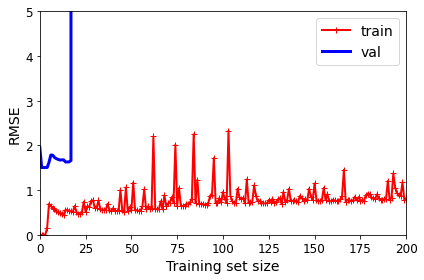

In [309]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 200, 0, 5])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()

Saving figure underfitting_learning_curves_plot


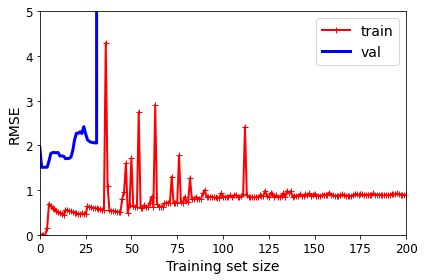

In [308]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 200, 0, 5])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()